**Class 3: Evaluating policies with samples**

1. [Everything you need to know](#everything)
2. [Reminder](#reminder)
3. [Evaluating policies as a stochastic approximation problem](#evaluating)
4. [Monte Carlo sampling](#monte)
5. [Temporal difference learning](#temporal)
6. [Delayed updates and experience replay for TD(0)](#batch)
    1. [Delayed updates](#delayed)
    2. [Experience replay](#experience)
7. [The importance of the behavior distribution](#behavior)
8. [TD($\lambda$)](#tdlambda)
9. [Summary](#summary)
10. [A few notes on value function approximation](#approx)
    1. [Linear value function approximation](#linear)
    2. [The tabular case is just a specific case of linear approximation](#tab)
    3. [TD($\lambda$) as a linear approximation update](#param)
    4. [Non-parametric models](#nonparam)

The previous classes introduced MDPs and the Bellman equations (evaluation and optimality). These equations involve the MDP's model (transition and reward functions). We saw how to solve these equations using the model. In this class, we will investigate how one can aim to solve the evaluation equation with samples rather than with the model.

<div class="alert alert-warning">

**Prerequisites:**
- Stochastic Approximation / Stochastic Gradient Descent
- Definition of a Markov Decision Process, a policy, a value function, a stationary distribution
- Evaluation equation
    
**Useful but not compulsory:**
- Bias/variance tradeoff
- Basic linear algebra
<div>

# <a id="everything"></a>Everything you need to know


Everything you should remember after this session.
<div class="alert alert-success">
<ul>
<li> Learning $V^\pi$ is a stochastic approximation problem with samples $g^\pi_t$ of $G^\pi_t = \sum\limits_{t = 0}^\infty \gamma^t R^\pi_t$.<br>
    Updates: $V(s_t) \leftarrow V(s_t) + \alpha \left[ g^\pi_t - V(s_t) \right]$ <br>
    Extension to batch SGD updates for $V_\theta$: $\theta \leftarrow \theta + \alpha \sum_{i=1}^N \left[ g^\pi(s_i) - V_\theta(s_i)\right] \nabla_\theta V_\theta(s_i)$.
<li> Monte Carlo sampling of $G^\pi_t$: $g^\pi_t = \sum_{i>t} \gamma^{i-t} r^\pi_i$.<br>
    Yields the online MC algorithm. Requires finite trajectories.
<li> Temporal Difference TD(0) learning: $g^\pi_t = r_t + \gamma V(s_{t+1})$.<br>
    Temporal difference $\delta = r + \gamma V(s') - V(s)$ or $\delta = r + \gamma Q(s',\pi(s')) - Q(s,a)$<br>
    Sample-based update. No need for finite trajectories.<br>
    When applied to $Q$ functions, does not require to simulate $\pi$: off-policy updates.
<li> Unifying MC and TD: TD($\lambda$).
</ul>
</div>

Of course, all this seems very obscure right now and the block above will only serve as a reminder when you re-open the notebook later. We will introduce every concept intuitively and progessively.

# <a id="reminder"></a>Reminder

**Value function:**  
$V^\pi(s)=\mathbb{E}\left[ \sum\limits_{t = 0}^\infty \gamma^t R_t \quad \Bigg| \quad \begin{array}{l}s_0 = s,\\ a_t=\pi(s_t),\\ s_{t+1}\sim p(s'|s_t,a_t),\\R_t = r(S_t,A_t,S_{t+1})\end{array} \right]$

**Evaluation equation(s):**  
$V^\pi$ is a solution to the linear system $V = T^\pi V$ with:
$$\left(T^\pi V\right) \left(s\right) = r\left(s,\pi(s)\right) + \gamma \mathbb{E}_{s' \sim p\left(s'|s,\pi(s)\right)} V\left(s'\right)$$  

$Q^\pi$ is a solution to the linear system $Q = T^\pi Q$ with:
$$\left(T^\pi Q\right) \left(s,a\right) = r\left(s,a\right) + \gamma \mathbb{E}_{s' \sim p\left(s'|s,a\right)} Q\left(s', \pi\left(s'\right)\right)$$

# <a id="evaluating"></a>Evaluating policies as a stochastic approximation problem

Let's write $G^\pi(s)$ the random variable of the overall return along a trajectory controled by $\pi$ and starting in $s$. With the previous notations:
$$G^\pi(s) = \sum\limits_{t = 0}^\infty \gamma^t R_t \quad \Bigg| \quad \begin{array}{l}s_0 = s,\\ a_t=\pi(s_t),\\ s_{t+1}\sim p(s'|s_t,a_t),\\R_t = r(S_t,A_t,S_{t+1}).\end{array}$$

Evaluating $V^\pi(s)$ is estimating the mathematical expectation of $G^\pi(s)$.

Stochastic approximation theory tells us that, given a series $g^\pi_t$ of independent realizations of $G^\pi(s)$, the sequence
$v_{t+1} = v_t + \alpha_t \left(g^\pi_t - v_t\right)$
converges to $\mathbb{E}\left(G^\pi(s)\right)$, if the sequence of $\alpha_t$ respects the Robbins-Monro conditions ($\sum_t \alpha_t = \infty$ and $\sum_t \alpha_t^2 < \infty$).

<a href="#morePpi" data-toggle="collapse">Intuitive explanation of Stochastic Approximation.</a><br>
<div id="morePpi" class="collapse">
    
For those unfamiliar with stochastic approximation procedures, we can understand the previous update as: $g^\pi_t$ are samples estimates of $\mathbb{E}\left(G^\pi(s)\right)$. If I already have an estimation of $v_t$ of $\mathbb{E}\left(G^\pi(s)\right)$ and I receive a new sample $g^\pi_t$, I should "pull" my previous estimate towards $g^\pi_t$. But $g^\pi_t$ carries a part of noise, so I should be cautious and only take a small step $\alpha$ in the direction of $g^\pi_t$.
    
In turn, the convergence conditions simply say that any value $V^\pi(s)$ should be reachable given any initial guess $V(s)$, no matter how far from $V^\pi(s)$ is from this first guess; hence the $\sum\limits_{t=0}^\infty \alpha_t = \infty$. However, we still need the step-size to be decreasing so that we don't start oscillating around $V^\pi(s)$ when we get closer; so to insure convergence we impose $\sum\limits_{t=0}^\infty \alpha_t^2 < \infty$.
</div>

So this provides us with a way to estimate $V^\pi(s)$ from experience samples rather than from a model.  
<div class="alert alert-success">
    
**Policy evaluation as stochastic approximation**  
If we can obtain independent realizations $g^\pi(s)$ of $G^\pi(s)$ in all $s$, we can perform stochastic approximation updates of $V$ under the form:
$$V(s) \leftarrow V(s) + \alpha \left(g^\pi(s) - V(s)\right).$$
Then $V$ converges to $V^\pi$.
</div>

A more modern formulation of Stochastic Approximation is Stochastic Gradient Descent. So we will slightly generalize the formulation above.  

$V^\pi$ is the function that minimizes
$$L(V) = \int_S \left[ V(s) - \mathbb{E}\left(G^\pi(s)\right)\right]^2 ds.$$

Recall that in the most general case, $V$ is a function, but for the sake of clarity, we will momentarily suppose that $S$ is finite and thus $V$ is equivalent to the vector of all $V(s)$ values.

Then, minimizing $L(V)$ can be done via gradient descent:
$$\nabla_V L(V) = \int_S 2 \left[ V(s) - \mathbb{E}\left(G^\pi(s)\right)\right] \nabla_V V(s) ds.$$

Suppose we have a set of independently drawn states $\left\{s_i\right\}_{i\in [1,N]}$. Then, this gradient can be approached via a Monte Carlo estimator:
$$\sum_{i=1}^N \left[ V(s_i) - \mathbb{E}\left(G^\pi(s_i)\right)\right] \nabla_V V(s_i).$$

In our example where $V$ is the vector of values taken in each state, 
$\nabla_V V(s_i) = \left[ \begin{array}{c} 0\\ \vdots\\ 0\\ 1 \\ 0\\ \vdots\\ 0 \end{array} \right]$ 
where the "1" is at the position corresponding to $s_i$ in the vector $V$.

As for Stochastic Approximation, if we can obtain independent realizations $g^\pi(s_i)$ of $G^\pi(s_i)$, then we can estimate this gradient as:
$$d = \sum_{i=1}^N \left[ V(s_i) - g^\pi(s_i)\right] \nabla_V V(s_i).$$

And thus we have the Stochastic Gradient Descent update:
$$V \leftarrow V - \alpha \sum_{i=1}^N \left[ V(s_i) - g^\pi(s_i)\right] \nabla_V V(s_i)$$

This update mechanism yields a sequence $V_t$ of value functions that converges to $V^\pi$ if the gradient steps $\alpha$ respect Robbins-Monro conditions.

<div class="alert alert-success">
    
**Policy evaluation as Stochastic Gradient Descent**  
If we can obtain independent realizations $g^\pi(s)$ of $G^\pi(s)$ in all $s$, we can perform Stochastic Gradient Descent updates on $V$:
$$V \leftarrow V + \alpha \sum_{i=1}^N \left[ g^\pi(s_i) - V(s_i)\right] \nabla_V V(s_i).$$
Then $V$ converges to $V^\pi$.
</div>

Note that if $N=1$, the update above falls back to the Stochastic Approximation update: having a sample in $s_i$ only updates $V(s_i)$.

<div class="alert alert-warning"><b>Exercise</b><br>
Redo the derivation above when $V$ is a parametric function $V_\theta$.
</div>

<div class="alert alert-danger"><a href="#SGD" data-toggle="collapse"><b>Answer:</b></a><br>
<div id="SGD" class="collapse">

The loss function becomes $L(\theta) = \int_S \left[ V_\theta(s) - \mathbb{E}\left(G^\pi(s)\right)\right]^2 ds$.
    
The gradient estimator becomes:
$$d = \sum_{i=1}^N \left[ V_\theta(s_i) - g^\pi(s_i)\right] \nabla_\theta V_\theta(s_i).$$

And so the update becomes:
$$\theta \leftarrow \theta + \alpha \sum_{i=1}^N \left[ g^\pi(s_i) - V_\theta(s_i)\right] \nabla_\theta V_\theta(s_i)$$
</div>
</div>

<div class="alert alert-warning"><b>Exercise</b><br>
Redo the derivation above for a finite-dimensional function $Q$, then a parametric function $Q_\theta$.
</div>

<div class="alert alert-danger"><a href="#SGD-Q" data-toggle="collapse"><b>Answer:</b></a><br>
<div id="SGD-Q" class="collapse">

When working with $Q(s,a)$ functions we need to define $G^\pi(s,a)$. Since
$Q^\pi(s,a)=\mathbb{E}\left[ \sum\limits_{t = 0}^\infty \gamma^t R_t \quad \Bigg| \quad \begin{array}{l}s_0 = s, a_0=a\\ a_t=\pi(s_t)\textrm{ for }t>0,\\ s_{t+1}\sim p(s'|s_t,a_t),\\R_t = r(S_t,A_t,S_{t+1})\end{array} \right],$
we have 
$$G^\pi(s,a) = \sum\limits_{t = 0}^\infty \gamma^t R_t \quad \Bigg| \quad \begin{array}{l}s_0 = s, a_0=a\\ a_t=\pi(s_t)\textrm{ for }t>0,\\ s_{t+1}\sim p(s'|s_t,a_t),\\R_t = r(S_t,A_t,S_{t+1}).\end{array}.$$
    
For a generic, finite-dimensional function $Q$, the loss function is 
$$L(Q) = \int_S \int_A \left[ Q(s,a) - \mathbb{E}\left(G^\pi(s,a)\right)\right]^2 ds da.$$
    
The gradient estimator becomes:
$$d = \sum_{i=1}^N \left[ Q(s_i,a_i) - g^\pi(s_i,a_i)\right] \nabla_Q Q(s_i,a_i).$$

And so the update becomes:
$$Q \leftarrow Q + \alpha \sum_{i=1}^N \left[ g^\pi(s_i,a_i) - Q(s_i,a_i)\right] \nabla_Q Q(s_i).$$
    
For a parametric function $Q_\theta$, the loss function becomes 
$$L(\theta) = \int_S \int_A \left[ Q_\theta(s,a) - \mathbb{E}\left(G^\pi(s,a)\right)\right]^2 ds da.$$

The gradient estimator becomes:
$$d = \sum_{i=1}^N \left[ Q_\theta(s_i,a_i) - g^\pi(s_i,a_i)\right] \nabla_\theta Q_\theta(s_i,a_i).$$

And so the update becomes:
$$\theta \leftarrow \theta + \alpha \sum_{i=1}^N \left[ g^\pi(s_i,a_i) - Q_\theta(s_i,a_i)\right] \nabla_\theta Q_\theta(s_i).$$
</div>
</div>

So, overall, if we manage to draw independent samples $g^\pi(s_i)$ of $G^\pi(s)$ in all $s\in S$, we can **learn** the value $V^\pi$ (or $Q^\pi$) of policy $\pi$.  
We will now introduce a few methods that differ only in how they calculate the $g^\pi(s_i)$ samples.

# <a id="monte"></a>Monte Carlo sampling

We wish to estimate $V^\pi(s)$ but we don't have access to the MDP's model. Instead, we can interact with it and draw experience samples.

Then, an immediate way to estimate $V^\pi(s)$ is to take the empirical average of a series if realizations of the $\sum\limits_{t = 0}^\infty \gamma^t R_t$ random variable.

In plain words: simulate $\pi$ from $s$ a certain number of times to obtain trajectories, observe and accumulate the rewards along each trajectory, take the empirical average over all trajectories.

That is precisely what we did in the first class to estimate the value of the starting state.

In [3]:
# %load solutions/RL1_exercice1.py
### WRITE YOUR CODE HERE
# If you get stuck, uncomment the line above to load a correction in this cell (then you can execute this code).

import gym
import gym.envs.toy_text.frozen_lake as fl
import numpy as np
from tqdm.notebook import trange

env = gym.make('FrozenLake-v0')

nb_episodes = 100000
horizon = 200
gamma = 0.9
Vepisode = np.zeros(nb_episodes)
for i in trange(nb_episodes):
    env.reset()
    for t in range(horizon):
        next_state, r, done,_ = env.step(fl.RIGHT)
        Vepisode[i] += gamma**t * r
        if done:
            break
print("value estimate:", np.mean(Vepisode))
print("value variance:", np.std(Vepisode))



value estimate: 0.013286309084390775
value variance: 0.0761077431172768


Now can we generalize this to learning the value $V^\pi$ in all states?

Let us start with a fully **offline Monte-Carlo** algorithm. The idea is simple: start from $s$, run the policy until termination (or for a long number of steps), repeat for a number of episodes, then update the value of all encountered states. This requires to store in memory full episodes (it also requires that the episodes be finite-length).

But we can immediately do better with an **online Monte-Carlo** method. It is almost the same idea: start from $s$, run the policy until termination (or for a long number of steps) then update the value of all encountered states before restarting an episode.  

Let $(s_0, r_0, s_1, \ldots, s_T)$ be the sequence of transitions of such an episode.  
For the sake of clarity we will slim down our notations: $g^\pi(s_t)$ becomes $g_t$.  
Then, this sequence provides a sample $g_t$ of $G^\pi(s_t)$ for all $s_t$ visited during the simulations. 
<div class="alert alert-success"><b>Monte Carlo return:</b>
$$g_t = \sum_{i>t} \gamma^{i-t} r_i$$
</div>

<div class="alert alert-warning">
    
**Exercise:**  
Consider the policy that always moves right in FrozenLake and implement an online Monte-Carlo estimatior for $g_t$, that you will use in a Stochastic Approximation method to obtain $V^\pi$.  
We decide we can tolerate a 0.001 error on $V^\pi$ so, to keep things simple, we set a constant $\alpha=0.001$.  
Take $\gamma = 0.9$. Run 100000 episodes of maximum 1000 time steps each.  
After each episode, compare the value function obtained with that computed with the model-based approaches of the previous class (use the cell below to recall `V_pi0` from the previous class).
</div>

In [ ]:
%load solutions/RL2_exercise5.py


[0.01460524 0.0116672  0.02965184 0.         0.01978357 0.
 0.06083133 0.         0.05169227 0.15472781 0.18644593 0.
 0.         0.28891098 0.57793886 0.        ]
[0.01307768 0.01175958 0.02743902 0.         0.01875499 0.
 0.06402439 0.         0.04943897 0.14604158 0.18597561 0.
 0.         0.30082967 0.55589431 0.        ]


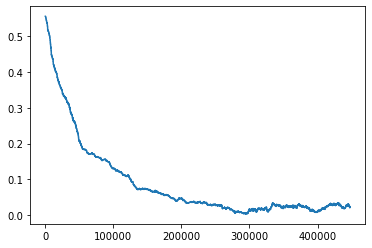

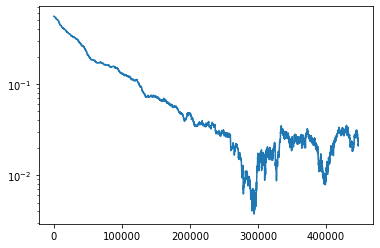

In [12]:
# %load solutions/RL3_exercise1.py
### WRITE YOUR CODE HERE
# If you get stuck, uncomment the line above to load a correction in this cell (then you can execute this code).

import gym
import gym.envs.toy_text.frozen_lake as fl
import numpy as np
%matplotlib inline
import matplotlib.pyplot as plt

env = gym.make('FrozenLake-v0')

# parameters
gamma = 0.9
alpha = 0.001
max_steps = 1000
max_episodes = 100000
V = np.zeros((env.observation_space.n))

# error plotting
error = np.zeros((max_episodes)) # used to track the convergence to V_pi0...
cumulated_steps = np.zeros((max_episodes)) # ... against the number of samples

for ep in trange(max_episodes):
    x = env.reset()
    episode = []
    # Run episode
    for t in range(max_steps):
        y,r,d,_ = env.step(fl.RIGHT)
        episode.append([x,r])
        if d==True:
            cumulated_steps[ep] = cumulated_steps[ep-1] + t
            break
        else:
            x=y
    # Update values
    T = len(episode)
    G = np.zeros((T))
    G[-1] = episode[-1][1] # derniere recompense
    x = episode[-1][0]
    V[x] = V[x] + alpha * (G[-1] - V[x])
    for t in range(-2,-T-1,-1):
        G[t] = episode[t][1] + gamma*G[t+1]
        x = episode[t][0]
        V[x] = V[x] + alpha * (G[t] - V[x])
    error[ep] = np.max(np.abs(V-V_pi0))

print(V)
print(V_pi0)
plt.plot(cumulated_steps,error)
plt.figure()
plt.semilogy(cumulated_steps,error);


So online Monte-Carlo allows us to update $V^\pi$ episode after episode. Some values are better estimated than others depending on how often the corresponding state was visited.

Monte-Carlo estimation has some flaws nonetheless. It still requires to store one full episode in memory before $V$ is updated. Also, one rare value for $r_t$ affects directly all the value of the states encountered before $s_t$. So we can question the robustness of this estimator.

# <a id="temporal"></a>Temporal difference learning

We want to replace Monte-Carlo (MC) estimation by a step by step update that only takes $(s_t,r_t,s_{t+1})$ as an input. The key remark we make is that once the $(s_t,r_t,s_{t+1})$ transition is over we can update our knowledge of $V(s_t)$ by using $r_t+\gamma V(s_{t+1})$. This estimate uses $V(s_{t+1})$ to *bootstrap*[1] the estimator of $V(s_t)$.

[1] This *bootstrap* operation has nothing to do with the statistical procedure of *bootstrapping*.

To get an intuitive understanding of why we can do that, take the following example. You are driving from home to the airport. Half-way, you realize traffic is denser than you usually estimate and you're already 5 minutes behind schedule. Home is $s_t$, half-way is $s_{t+1}$, the elapsed time between $s_{t}$ and $s_{t+1}$ is $r_t$. To update your belief $V(s_t)$ about the average length of the trip home$\rightarrow$airport, you don't need to wait until you reach the airport (as a Monte-Carlo estimate would have required). Instead, you can update this belief using $r_t+V(s_{t+1})$, the sum of what you just observed and what you currently estimate for the rest of the trip. As long as you update all states often enough, the whole procedure should converge to the true $V$.

This idea, which was first introduced in R. Sutton's **[Learning to predict by the methods of temporal differences](https://link.springer.com/article/10.1007/BF00115009)** article, has a strong parallel with the evaluation equation. This equation was:
$$V^\pi \left(s\right) = r\left(s,\pi(s)\right) + \gamma \mathbb{E}_{s' \sim p\left(s'|s,\pi(s)\right)} V^\pi \left(s'\right)$$  

What we expressed intuitively in the previous paragraph is that the sample $g_t$ of $V^\pi(s_t)$ can be built by summing $r_t$ and $\gamma V_t(s_{t+1})$:
$$g_t = r_t + \gamma V_t(s_{t+1}).$$

Note that in the expression above, we have used $V_t$ to emphasize that we use the function $V$ as it was at time step $t$ to define the target $g^\pi_t$ used in the update that will provide $V_{t+1}$.

Formally, this comes directly from the evaluation operator. Let's rewrite $T^\pi$ in terms of random variables.
$$(T^\pi V)(s) = \mathbb{E}_{R,S'}\left[ R + \gamma V(S') \right]$$

Since $V^\pi$ is the fixed point of $T^\pi$, by taking $g_t = r_t + \gamma V_t(s_{t+1})$ we are taking one stochastic approximation step in the direction of $T^\pi V_t$. 

**Bootstrapping** (in this particular context) is the operation of using the value of $V_t(s_{t+1})$ in the update of $V$.

Then the stochastic approximation update becomes what is called the **TD(0) update**:
<div class="alert alert-success">
    
**TD(0) update:**  
$$V(s_t) \leftarrow V(s_t) + \alpha \left(r_t + \gamma V(s_{t+1}) - V(s_t)\right).$$
    
This update consists in taking one stochastic approximation step in the direction of $T^\pi V$.
</div>

The generalization to the batch stochastic gradient descent update is:
$$V \leftarrow V + \alpha \sum_{i=1}^N \left[ r_i + \gamma V(s_{i+1}) - V(s_i)\right] \nabla_V V(s_i).$$

And in particular, for a parametric function $V_\theta$:
$$\theta \leftarrow \theta + \alpha \sum_{i=1}^N \left[ r_i + \gamma V(s_{i+1}) - V(s_i) \right] \nabla_\theta V_\theta(s_i)$$

Let's stress this out one last time:  
TD(0) does not directly solve $V=\mathbb{E}\left[\sum_t\gamma^t R_t \right]$, contrarily to MC. Instead, it implements stochastic approximation on top of the repeated application of the $T^\pi$ operator. So it solves $V_{n+1} = T^\pi V_n$. At each step $t$, it takes the current value function $V_t$, draws one or several samples from $T^\pi V_t$ and approximates $T^\pi V_t$ by taking one step of gradient descent from $V_t$.

$\delta_t=r_t + \gamma V_t(s_{t+1}) - V_t(s_t)$ is called the prediction **temporal difference** (hence the name TD(0) for the algorithm - the "0" will be explained in the section on TD($\lambda$)). It is the difference between our estimate $V_t(s_t)$ *before* obtaining the information of $r_t$, and the bootstrapped value $r_t+\gamma V_t(s_{t+1})$.
<div class="alert alert-success"><b>Temporal difference:</b>
$$\delta=r + \gamma V(s') - V(s)$$
</div>

The TD(0) update is a sample-by-sample update (no need to remember full episodes) and, more importantly, it is adapted to non-episodic environments (with no terminal states).

Often, TD methods converge faster and are more robust estimators than Monte Carlo ones (but not always).

<div class="alert alert-warning">
    
**Exercise:**  
Consider the policy that always moves right in FrozenLake and implement a TD(0) estimation for $V^\pi$.  
Again, we decide we can tolerate a 0.001 error on $V^\pi$ so, to keep things simple, we set $\alpha=0.001$.  
Take $\gamma = 0.9$ and run the algorithm for 2000000 time steps.<br>
After each episode, compare the value function obtained with that computed with the model-based approaches of the previous class.
</div>


[0.01241707 0.01162678 0.02622748 0.         0.01754208 0.
 0.06231301 0.         0.04779655 0.14152244 0.18349582 0.
 0.         0.2998404  0.55989421 0.        ]
[0.01307768 0.01175958 0.02743902 0.         0.01875499 0.
 0.06402439 0.         0.04943897 0.14604158 0.18597561 0.
 0.         0.30082967 0.55589431 0.        ]


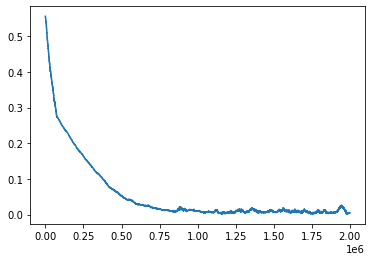

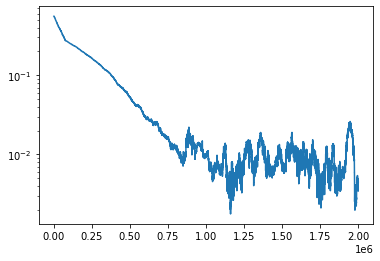

In [14]:
# %load solutions/RL3_exercise2.py
### WRITE YOUR CODE HERE
# If you get stuck, uncomment the line above to load a correction in this cell (then you can execute this code).

import gym
import gym.envs.toy_text.frozen_lake as fl
import numpy as np
%matplotlib inline
import matplotlib.pyplot as plt

env = gym.make('FrozenLake-v0')

# parameters
gamma = 0.9
alpha = 0.001
max_steps = 2000000
V = np.zeros((env.observation_space.n))

# error plotting
error = np.zeros((max_steps)) # used to track the convergence to V_pi0

x = env.reset()
for t in trange(max_steps):
    y,r,d,_ = env.step(fl.RIGHT)
    V[x] = V[x] + alpha * (r+gamma*V[y]-V[x])
    error[t] = np.max(np.abs(V-V_pi0))
    if d==True:
        x = env.reset()
    else:
        x=y

print(V)
print(V_pi0)
plt.plot(error)
plt.figure()
plt.semilogy(error);

<div class="alert alert-warning"><b>Exercise:</b><br>
In the previous exercise, every experience sample $(s,r,s')$ was obtained by simulating $\pi$. Why is it necessary to simulate $\pi$? What would happen if we simulated another policy?
</div>

<div class="alert alert-danger"><a href="#TD-V" data-toggle="collapse"><b>Answers:</b></a><br>
<div id="TD-V" class="collapse">

We need to simulate $\pi$ because of the definition of $g^\pi_t$: it is a realization of the overall return *under policy $\pi$*.
    
In Monte Carlo estimation, if we run another policy $\pi'$, then we obtain samples for $g^{\pi'}_t$ which are not informative for the estimation of $V^\pi$.
    
In TD learning, even if $V(s')$ is a good estimator of $V^\pi(s')$, we need $s'$ to be sampled according to $p(s'|s,\pi(s))$ to obtain unbiased samples $r + \gamma V(s')$.
</div>
</div>

<div class="alert alert-warning">
    
**Exercise:**  
Can you design a TD(0) algorithm on state-action values functions $Q(s,a)$ that estimates $Q^\pi$ for a given policy $\pi$?  
Does this algorithm require that the transitions from $s$ to $s'$ be sampled using $\pi$?
</div>

<div class="alert alert-danger"><a href="#TD-Q" data-toggle="collapse"><b>Answers:</b></a><br>
<div id="TD-Q" class="collapse">
We wish to estimate $Q(s,a)$:
$$Q^\pi(s,a) = \mathbb{E}\left( \sum\limits_{t=0}^\infty \gamma^t r\left(s_t, a_t\right) \bigg| s_0 = s, a_0=a, \pi \right) = r(s,a) + \gamma \sum\limits_{s'\in S}p(s'|s,a) Q^\pi(s',\pi(s'))$$

So we can write our temporal difference by bootstrapping with $Q(s',\pi(s'))$. Suppose the last sample was $(s,a,r,s')$.
$$\delta = r + \gamma Q(s',\pi(s')) - Q(s,a)$$
And the update of $Q$ goes as:
$$Q(s,a) \leftarrow Q(s,a) + \alpha \delta$$
As long as all state-action pairs $(s,a)$ are sampled infinitely often as $t\rightarrow\infty$, and under the Robbins-Monro conditions, this procedure should converge to $Q^\pi$. So the transitions should be sampled for every state-action pair and thus do not require to apply $\pi(s)$ in $s$.
</div>
</div>

<div class="alert alert-success"><b>TD(0) temporal difference update on $Q$-functions:</b><br>
For a sample $(s,a,r,s')$, the temporal difference is:
$$\delta = r + \gamma Q(s',\pi(s')) - Q(s,a)$$
And the TD update is:
$$Q(s,a) \leftarrow Q(s,a) + \alpha \left[ r + \gamma Q(s',\pi(s')) - Q(s,a) \right]$$
As long as all state-action pairs $(s,a)$ are sampled infinitely often as $t\rightarrow\infty$, and under the Robbins-Monro conditions, this procedure converges to $Q^\pi$.
</div>

Interestingly, in the exercise above, the samples $(s,a,r,s')$ do not require $a=\pi(s)$. Even better, they actually require to try all possible actions in $s$ for the procedure to converge (not only $\pi(s)$). So this TD(0) algorithm on $Q$-functions is an **off-policy** algorithm. One can obtain the value $Q^\pi$ of a policy $\pi$ without applying $\pi$ for sample collection. This will prove very useful during the class on model-free control.

We will call $\beta$ the *behavior policy*. It is the policy being applied to interact with the environment. Off-policy evaluation algorithms can use a behavior policy that is different than the policy being evaluated. We will call *behavior distribution* the distributions $\rho^\beta(s)$ over states and $\rho^\beta(s,a)$ over state-action pairs, induced by applying $\beta$.

<div class="alert alert-warning"><b>Exercise:</b><br>
Let's implement TD(0) on $Q$-functions.<br>
To insure that all states and actions are sampled infinitely often, take a behavior policy that acts randomly in each state.<br>
Take $\gamma=0.9$ and run the algorithm for 2000000 time steps.<br>
In order to speed up convergence, we can initialize $Q(s,a)$ to the value found previously for $V^\pi(s)$.<br>
Use the cell below (inspired from the class on model-based policy evaluation) to retrieve the true value of $Q^\pi$ and display convergence of TD(0).
</div>

In [20]:
import gym
import gym.envs.toy_text.frozen_lake as fl
import numpy as np

# Model based evaluation
def policy_Qeval_iter(pi, epsilon, max_iter):
    Q1 = np.zeros((env.observation_space.n, env.action_space.n))
    Q2 = np.zeros((env.observation_space.n, env.action_space.n))
    residuals = np.zeros((max_iter))
    for i in range(max_iter):
        for x in range(env.observation_space.n):
            for a in range(env.action_space.n):
                Q2[x][a] = 0
                outcomes = env.unwrapped.P[x][a]
                for o in outcomes:
                    p = o[0]
                    y = o[1]
                    r = o[2]
                    Q2[x][a] += p * (r + gamma*Q1[y][pi[y]])
        residuals[i] = np.max(np.abs(Q2-Q1))
        Q1[:] = Q2
        if residuals[i]<epsilon:
            residuals = residuals[:i+1]
            break
    return Q1, residuals


Qtrue:
 [[0.01336154 0.01299541 0.01299541 0.01128441]
 [0.0074009  0.01210468 0.01173854 0.01562206]
 [0.0309353  0.02271414 0.02741792 0.01173854]
 [0.00822116 0.00822116 0.         0.00822116]
 [0.02428337 0.02039986 0.01868886 0.00947803]
 [0.         0.         0.         0.        ]
 [0.06400324 0.05578208 0.06400324 0.00822116]
 [0.         0.         0.         0.        ]
 [0.02039986 0.05859612 0.04938528 0.06419063]
 [0.10502161 0.16080369 0.14599835 0.07058743]
 [0.22974521 0.21054845 0.18595444 0.06298753]
 [0.         0.         0.         0.        ]
 [0.         0.         0.         0.        ]
 [0.13400704 0.25697394 0.30076472 0.21054845]
 [0.31275603 0.59030728 0.5558731  0.47933168]
 [0.         0.         0.         0.        ]]
number of iterations: 18



Max error: 0.019736193946709057


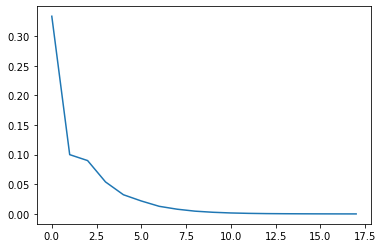

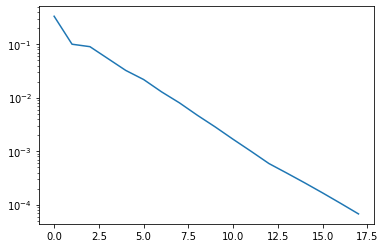

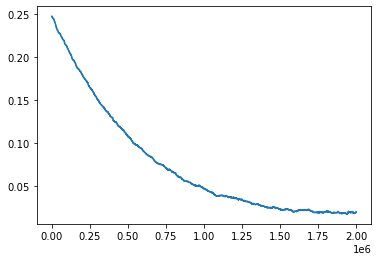

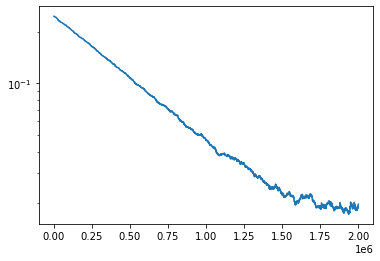

In [21]:
# %load solutions/RL3_exercise3.py
### WRITE YOUR CODE HERE
# If you get stuck, uncomment the line above to load a correction in this cell (then you can execute this code).

import gym
import gym.envs.toy_text.frozen_lake as fl
import numpy as np
%matplotlib inline
import matplotlib.pyplot as plt

env = gym.make('FrozenLake-v0')

# Policy definition and parameters
pi0 = fl.RIGHT*np.ones((env.observation_space.n),dtype=np.int)
gamma = 0.9
alpha = 0.001

Qtrue, residuals = policy_Qeval_iter(pi0,1e-4,10000)
print("Qtrue:\n", Qtrue)
print("number of iterations:", residuals.size)
plt.plot(residuals)
plt.figure()
plt.semilogy(residuals)

# TD(0) evaluation of Qpi
# parameters
gamma = 0.9
alpha = 0.001
max_steps=2000000
Q = np.transpose(np.tile(V, (4,1)))

error = np.zeros((max_steps))
x = env.reset()
for t in trange(max_steps):
    a = np.random.randint(4)
    y,r,d,_ = env.step(a)
    Q[x][a] = Q[x][a] + alpha * (r+gamma*Q[y][fl.RIGHT]-Q[x][a])
    error[t] = np.max(np.abs(Q-Qtrue))
    if d==True:
        x = env.reset()
    else:
        x=y

print("Max error:", np.max(np.abs(Q-Qtrue)))
plt.figure()
plt.plot(error)
plt.figure()
plt.semilogy(error);

So now we have a way to *learn* $Q^\pi$ for a given policy $\pi$. This provides us with a way to run Policy Iteration without a model and thus build an agent that learns an optimal policy from samples. This will be covered in the next class.

# <a id="batch"></a>Delayed updates and experience replay for TD(0)

For the sake of clarity and re-usability we will work directly with $Q$ functions in what follows but the same argument holds for $V$ functions.

## <a id="delayed"></a>Delayed updates

We have seen that TD(0), at each time step, takes a gradient step in the direction of $T^\pi Q$.

The result of this gradient step is an approximation of $T^\pi Q$.

The previous class on model-based policy optimization indicated that despite an approximation operator $\mathcal{A}$ with controlled error, the sequence $V_{n+1} = \mathcal{A} T^\pi V_n$ still converged to a neighborhood of $V^\pi$. The same result holds for the sequence $Q_{n+1} = \mathcal{A} T^\pi Q_n$.

One single step of stochastic gradient descent makes for a poor approximator. Given a fixed function $Q_n$, if we repeat a certain number $C$ of such gradient steps, we can hope to obtain a better estimate of $T^\pi Q_n$. So there is an interest in keeping two $Q$ functions. The first is the current estimator, which plays the role of $Q_n$, upon which we apply $T^\pi$, and which we call the *target* function $Q^-$. The second is the one we actually optimize upon and which aims at approximating $T^\pi Q^-$; we write it $Q$. Every $C$ gradient steps, we replace $Q^-$ by $Q$ and repeat.

Consequently, this procedure of delayed updates trades off advancing in the $Q_{n+1} = \mathcal{A} T^\pi Q_n$ sequence for better approximation properties for $\mathcal{A}$.

This makes more apparent the remark made before that TD(0) actually solves the $Q_{n+1} = T^\pi Q_n$ sequence and thus successively minimizes a sequence of losses:
$$L_n(Q) = \| Q - T^\pi Q_n \|_2.$$
The loss changes everytime we replace $Q_n$ by $Q$.

<div class="alert alert-warning">
    
**Exercise:**  
What's the value of $C$ in vanilla TD(0)?
</div>

<div class="alert alert-danger"><a href="#vanillaTD0" data-toggle="collapse"><b>Answers:</b></a><br>
<div id="vanillaTD0" class="collapse">
Vanilla TD(0) replaces $Q^-$ by $Q$ at every step, so $C=1$.
</div>
</div>

## <a id="experience"></a>Experience replay
In order to be able to perform stochastic gradient steps using more than one sample, one needs to keep samples in memory.

Recall the loss we defined to introduce the stochastic gradient update:
$$L(Q) = \int_S \left[ Q(s) - \mathbb{E}\left(G^\pi(s)\right)\right]^2 ds da.$$

Recall also that $d = \sum_{i=1}^N \left[ Q(s_i) - g^\pi(s_i)\right] \nabla_Q Q(s_i)$ is an unbiased estimate of $\nabla_Q L(Q)$ only if the $g^\pi(s_i)$ are drawn **independently** and **identically** according to the distribution of $G^\pi(s)$.

This last condition can only be verified if 
1. the $s_i$ are drawn independently of each other and always according to the same distribution $\rho(s)$, and
2. given $s_i$, the realizations $g^\pi(s_i)$ are drawn independently of each other and according to the distribution of $G^\pi(s_i)$.

<div class="alert alert-warning">
    
**Exercise:**  
What do you think? Is condition 1 verified in vanilla TD(0)? What about condition 2?
</div>

<div class="alert alert-danger"><a href="#iid" data-toggle="collapse"><b>Answers:</b></a><br>
<div id="iid" class="collapse">

Let's write $(s_i,a_i,r_i,s'_i)$ the $i$th sample and $\beta$ the behavior policy.
    
Condition 1 is not verified for vanilla TD(0). It is true that if the behavior policy is constant, then on average the samples $s_i$ are drawn **identically**, according this policy's stationary state distribution $\rho^\beta(s)$. However, successive samples are not drawn **independently** by definition, since $\mathbb{P}(S_{t+1})$ is actually conditionned by $S_t$ and $A_t=\beta(S_t)$.

    
Condition 2, on the other hand is easier to verify for TD(0) updates: since the reward $r_i$ and the next state $s'_i$ are only conditionned by $s_i$ and $a_i=\beta(s_i)$, the $g^\pi(s_i) = r_i + \gamma Q(s'_i,\pi(s'_i))$ are all drawn identically and independently of each other.
</div>
</div>

Despite this, TD(0) with tabular function representation still converges as long as states and actions are tried frequently enough. In some cases of function approximation this is also still true. But we might have found a major issue here in the most general case.

One way to (approximately) recover the conditional independence of sampled states $s_i$ is to store a large number of samples $(s_i,a_i,r_i,s'_i)$ in memory, and draw samples uniformly at random from this memory for the TD(0) updates. This idea was first introduced by Lin in his 1992 **[Self-improving reactive agents based on reinforcement learning, planning and teaching](https://link.springer.com/article/10.1007/BF00992699)** article, under the name of *experience replay* (although his derivation was not exactly the same and applied to the Q-learning algorithm which we reserve for another class).

The memory of samples is generally called an *experience replay memory* or *experience replay buffer*, since it allows the learning agent to store past experience in memory and recall it (replay it) as many times as necessary to facilitate learning.

Drawing uniformly randomly from a replay buffer preserves the stationary distribution which generated the samples and breaks the conditional dependency between successive samples in a trajectory.

Combined with the delayed updates introduced earlier, this yields a general, practical algorithm:

<div class="alert alert-success">
    
**TD(0) with delayed updates and experience replay:**  
Given a set of samples $\left\{(s_i,a_i,r_i,s'_i)\right\}_{i\in [1,N]}$ all drawn from a fixed behavior distribution, and a *target* function $Q^-$, the gradient update is:
$$Q \leftarrow Q + \alpha \sum_{i=1}^N \left[ r_i + \gamma Q^-(s'_{i},\pi(s'_i)) - Q_\theta(s_i,a_i) \right] \nabla_Q Q(s_i,a_i)$$
As long as all state-action pairs $(s,a)$ are sampled infinitely often as $t\rightarrow\infty$, under the Robbins-Monro conditions, and under repeated substitution of $Q^-$ by $Q_\theta$ every $C$ gradient updates, this procedure converges to $Q^\pi$ that minimizes $\|Q - Q^\pi \|_2$.
</div>

We can write the same update in the case of parametric function approximation.

<div class="alert alert-success">
    
**TD(0) with delayed updates, experience replay and parametric function approximation:**  
Given a set of samples $\left\{(s_i,a_i,r_i,s'_i)\right\}_{i\in [1,N]}$ all drawn from a fixed behavior distribution, a *target* function $Q^-$,  and a parametric function approximator $Q_\theta$, the gradient update is:
$$\theta \leftarrow \theta + \alpha \sum_{i=1}^N \left[ r_i + \gamma Q^-(s'_{i},\pi(s'_i)) - Q_\theta(s_i,a_i) \right] \nabla_\theta Q_\theta(s_i,a_i)$$
As long as all state-action pairs $(s,a)$ are sampled infinitely often as $t\rightarrow\infty$, under the Robbins-Monro conditions, and under repeated substitution of $Q^-$ by $Q_\theta$ every $C$ gradient updates, this procedure converges to $\theta^\pi$ that minimizes $\|Q_\theta - Q^\pi \|_2$.
</div>

# <a id="behavior"></a>The importance of the behavior distribution

We have written above that TD(0) on $Q$ functions is an off-policy algorithm since it will estimate $Q^\pi$ whatever the behavior policy is, as long as this policy explores all state-action pairs infinitely often.

This is actually only true if we are working with tabular representations of $Q$ functions.

Let's return to the gradient descent formulation for a minute. We wrote that the loss was:
$$L(Q) = \int_S \int_A \left[ Q(s,a) - \mathbb{E}\left(G^\pi(s,a)\right)\right]^2 ds da.$$
    
And we wrote the Monte Carlo estimate of this loss' gradient:
$$d = \sum_{i=1}^N \left[ Q(s_i,a_i) - g^\pi(s_i,a_i)\right] \nabla_Q Q(s_i,a_i).$$

This is actually only correct if the samples $(s_i, a_i)$ are drawn uniformly in $S \times A$. But in practice, the samples are drawn in $S\times A$ according to the behavior distribution $\rho^\beta(s,a)$.

Let us get back to the general formulation of stochastic gradient descent. For this, we will introduce a distribution $\Gamma$ over $S\times A\times \mathbb{R}$ that describes the joint distribution of state-action pairs $(s,a)$ and long term returns $G^\pi(s,a)$ under policy $\pi$. So, given a behavior distribution $\rho^\beta(s,a)$, essentially:
$$\Gamma(s,a,g^\pi) = \rho^\beta(s,a) \mathbb{P}(G^\pi(s,a)=g^\pi|s,a)$$

Then finding $Q^\pi$ amounts to solving the minimization problem $\min_Q L(Q)$ with:
\begin{align*}
L(Q) &= \mathbb{E}_{s,a,g^\pi \sim \Gamma} \left[ \left(Q(s,a) - g^\pi\right) \right],\\
     &= \int_S \int_A \int_\mathbb{R} \left[ Q(s,a) - g^\pi \right]^2 \Gamma(s,a,g^\pi) ds da dg^\pi.
\end{align*}

Then, **if the samples $(s,a,g^\pi)$ are drawn according to $\Gamma(s,a,g^\pi)$**, the Monte Carlo estimate
$$d = \sum_{i=1}^N \left[ Q(s_i,a_i) - g^\pi(s_i,a_i)\right] \nabla_Q Q(s_i,a_i)$$
is actually a correct estimate of $\nabla_Q L(Q)$.

What does it mean that $(s,a,g^\pi)$ are drawn according to $\Gamma(s,a,g^\pi)$? It means state-action pairs are drawn according to $\rho^\beta(s,a)$ and the $g^\pi(s_i,a_i)$ follow the distribution of $G^\pi(s,a)$

Otherwise, this Monte Carlo estimate it is a biased estimator that minimizes another loss function; for example one defined by another behavior distribution $\rho^\beta(s,a)$.

So when we are summing elements drawn from the replay memory, or when we are using single samples drawn from the interaction with the MDP, we are actually minimizing the loss function defined specifically by $\rho^\beta(s,a)$. And in the end, for another behavior distribution, the resulting minimizer $Q$ of the loss might be different from the one obtained by using samples collected with $\rho^\beta$.

So, does that mean TD(0) on $Q$ functions is not really off-policy?

In the case of tabular representations, the fact that the gradients $\nabla_Q Q(s_i,a_i)$ are actually indicator functions of $(s_i, a_i)$ limits the impact of having different distributions on $S\times A$. In this case, the minimizers of $L(Q)$ are actually all the same across behavior distributions, as long as the behavior distribution's support spans fully $S\times A$.

However, this nice property is lost in the general case, in particular in the case of function approximation $Q_\theta$. This has motivated the introduction of the **[Gradient Temporal Difference](https://proceedings.neurips.cc/paper/2008/hash/e0c641195b27425bb056ac56f8953d24-Abstract.html)** family of algorithms. This topic is beyond the scope of this class but the interested reader is encouraged to look at **[H. R. Maei's PhD thesis](https://era.library.ualberta.ca/items/fd55edcb-ce47-4f84-84e2-be281d27b16a)**.

# <a id="tdlambda"></a>TD($\lambda$)

If this is the first time you read this notebook, this part can be skipped.

With Monte Carlo (MC) and TD(0), we have two methods with different features:
- TD(0): 1-sample update with bootstrapping
- MC: $\infty$-sample update with no bootstrapping

What's inbetween?
- inbetween: $n$-sample update with bootstrapping

We define the **$n$-step target** or **$n$-step return** $G^{(n)}_t$ from state $s_t$ as the random variable:

$$
\begin{array}{l|l}
G_t = R_t + \gamma R_{t+1} + \gamma^2 R_{t+2} + \ldots & \textrm{MC}\\
G^{(1)}_t = R_t + \gamma V_t(S_{t+1}) & 1\textrm{-step TD = TD(0)}\\
G^{(2)}_t = R_t + \gamma R_{t+1} + \gamma^2 V_t(S_{t+2}) & 2\textrm{-step TD}\\
G^{(n)}_t = R_t + \gamma R_{t+1} + \gamma^2 R_{t+2} + \ldots + \gamma^n V_t(S_{t+n}) & n\textrm{-step TD}
\end{array}
$$

And we define the **$n$-step TD update** as:
<div class="alert alert-success"><b>$n$-step TD update:<b>
$$V(s_t) \leftarrow V(s_t) + \alpha \left[ R^{(n)}_t - V(s_t) \right]$$
</div>

<div class="alert alert-warning">
    
**Exercise:**  
Suppose that the immediate reward $R$ has a constant variance $\sigma^2$ and that for all states $s$ the estimator $V(s)$ of $V^\pi(s)$ has bias $\epsilon$.  
What is the variance of $G_t^{(n)}$?  
What is the bias of $\mathbb{E}\left(G_t^{(n)}(s)\right)$ as an estimator of $V^\pi(s)$?  
Comment on the impact of choosing a certain value for $n$.
</div>

<div class="alert alert-danger"><a href="#biasvariance" data-toggle="collapse"><b>Answers:</b></a><br>
<div id="biasvariance" class="collapse">

Reminder: $var(X+Y)=var(X)+var(Y)$ and $var(aX)=a^2 var(X)$.  
Consequently:
\begin{align*}
    var(G_t^{(n)}) &= \sum_{i=0}^{n-1} \gamma^{2i} \sigma^2 + var(V_t(S_{t+n}))\\
     &= \frac{1-\gamma^n}{1-\gamma}\sigma^2 + var(V_t(S_{t+n}))
\end{align*}
    
The variance grows with $n$, both because $1-\gamma^n$ grows with $n$ and because $S_{t+n}$ has larger variance as $n$ grows.
    
On the bias side:
\begin{align*}
    \mathbb{E}\left(G_t^{(n)}(s)\right) - V^\pi(s) &= \mathbb{E}\left(G_t^{(n)}(s)\right) - \mathbb{E}\left(\sum_{i=0}^\infty \gamma^t R_t\right)\\
    &=\mathbb{E}\left(\sum_{i=0}^{n-1} \gamma^i R_{t+i} + \gamma^n V_t(S_{t+n})\right)  - \mathbb{E}\left(\sum_{i=0}^\infty \gamma^t R_t\right)\\
    &=\gamma^n \left[ \mathbb{E}\left(V_t(S_{t+n})\right) - \mathbb{E}\left(\sum_{i=n}^\infty \gamma^t R_t \right) \right]\\
    &=\gamma^n \left[ \mathbb{E}\left(V_t(S_{t+n})\right) - V_t(S_{t+n}) \right]\\
    &=\gamma^n \epsilon
\end{align*}
    
So the bias decreases with $n$. This makes sense since $V_t$'s importance is weighted by $\gamma^n$.
    
Consequently, choosing a value for $n$ is making a bias-variance tradeoff. Small $n$ means small variance an large bias, large $n$ means large variance and small bias. Thus, choosing an intermediate value has in interest in accelerating the convergence of TD algorithms.
</div>
</div>

So MC corresponds to an $\infty$-step TD update.  
    
The $n$-step TD update algorithm converges to the true $V^\pi$ just as TD(0) or MC. It requires to wait for $n$ time steps before performing an update.

Remark: for finite-length  episodes of length $T$, all $n$-step returns for $n>T-t$ are equal to the Monte Carlo return $G_t$.

So $n$-step TD updates bridge a gap between MC and TD(0). But it's not quite satisfying yet because we never really know what value of $n$ is appropriate to speed up convergence for a given problem. An interesting property is that we can mix $n$ and $m$-step returns together. Consider $G^{mix}_t = \frac{1}{3} G^{(2)}_t + \frac{2}{3} G^{(4)}_t$.
Then the update $V(s_t) \leftarrow V(s_t) + \alpha \left[G^{mix}_t - V(s_t)\right]$ still converges to $V^\pi$. More generally, convex sums of $n$-step returns yield update procedures that still converge to $V^\pi$.

Now, take $\lambda\in [0,1]$ and consider the $\lambda$-return $G^\lambda_t$:
<div class="alert alert-success"><b>$\lambda$-return:</b>
$$G^\lambda_t = \left(1-\lambda\right) \sum\limits_{n=1}^\infty \lambda^{n-1}G_t^{(n)}$$
</div>

The $\lambda$-return is the mixing of *all* $n$-step returns, with weights $(1-\lambda) \lambda^{n-1}$. So, an agent performing a $\lambda$-return update looks one step in the future and uses that step to update $V(s)$ with weight $(1-\lambda)$, then looks 2 steps into the future and updates $V(s)$ with a weight $\lambda (1-\lambda)$ and so on. The illustrative figure below is an excerpt from **Reinforcement Learning: an introduction** by Sutton and Barto.

<img src="img/TD_lambda_forward.png"></img>

To get a better understanding of the $\lambda$-return and to set ideas, let us consider a finite length episode $(s_t, r_t, s_{t+1}, \ldots, s_T)$. Since the episode ends after $T$, we have $\forall k>0, \ G^{(T-t+k)}_t = G_t$. Thus, we can split the $\lambda$-return sum in two:

\begin{align*}
G^\lambda_t & = \left(1-\lambda\right) \sum\limits_{n=1}^{T-t-1} \lambda^{n-1}G_t^{(n)} + \left(1-\lambda\right) \sum\limits_{n=T-t}^{\infty} \lambda^{n-1}G_t^{(n)}\\
& = \left(1-\lambda\right) \sum\limits_{n=1}^{T-t-1} \lambda^{n-1}G_t^{(n)} + \left(1-\lambda\right) \lambda^{T-t-1} \sum\limits_{n=T-t}^{\infty} \lambda^{n-T+t} G_t^{(n)}\\
& = \left(1-\lambda\right) \sum\limits_{n=1}^{T-t-1} \lambda^{n-1}G_t^{(n)} + \left(1-\lambda\right) \lambda^{T-t-1} \sum\limits_{k=0}^{\infty} \lambda^{k} G_t^{(T-t+k)}\\
& = \left(1-\lambda\right) \sum\limits_{n=1}^{T-t-1} \lambda^{n-1}G_t^{(n)} + \lambda^{T-t-1} G_t\\
\end{align*}

So we have $G^\lambda_t = \left(1-\lambda\right) \sum\limits_{n=1}^{T-t-1} \lambda^{n-1}G_t^{(n)} + \lambda^{T-t-1} G_t$.
- When $\lambda = 0$, it is a $TD(0)$ update (hence the "0" in TD(0)).
- When $\lambda = 1$, it is a MC update.
So we can define the **$\lambda$-return algorithm** that generalizes on TD(0) and MC:
<div class="alert alert-success"><b>$\lambda$-return algorithm:</b>
$$V(s_t) \leftarrow V(s_t) + \alpha \left[G^{\lambda}_t - V(s_t)\right] $$
</div>

That's all very nice and we have replaced the choice of $n$ by the choice of $\lambda$, which seems less sensitive. But, still, we don't know how to compute those $n$-step returns, and the $\lambda$-return, without running $n$-step episodes (and thus infinite episodes for the $\lambda$-return in the general case).

This is where we need to flip the little man in the drawing above to make him look backwards in time. When an agent transitions from $s$ to $s'$ and obtains reward $r$, it can compute the $1$-step return for $s$ and perform the corresponding $1$-step TD update. Then, as it transitions from $s'$ to $s''$ and observes $r'$ it can perform the $1$-step TD update in $s'$, but also the $2$-step TD update in $s$! An so on for future transitions. So, incrementally, as time unrolls, the agent will include the $n$-step updates in the $\lambda$-return of $s$ as they become available. In the limit, when $t\rightarrow\infty$, the $\lambda$-return in every state will be complete and the agent will have completed a $\lambda$-return algorithm. This figure below (excerpt from **Reinforcement Learning: an introduction** by Sutton and Barto) illustrates this *backward-view* on TD updates.

<img src="img/TD_lambda_backward.png"></img>

This seems to imply that we need to remember the states we went through, which is quite the same as remembering full episodes for MC updates. But since we want to update a state seen $n$ steps ago with a weight $\lambda^n (1-\lambda)$, we just need to remember, for each state, the last time we visited it (and we can forget about the trajectory linking states together). This way, we store $|S|$ values at all time, instead of an increasingly long sequence of transitions. In order to do this, we introduce the notion of **eligibility trace**:
<div class="alert alert-success"><b>Eligibility trace of state $s$:</b>
$$e_t(s) = \left\{\begin{array}{ll}
\gamma \lambda e_{t-1}(s) & \textrm{if }s\neq s_t\\
1 & \textrm{if }s = s_t
\end{array}\right.$$
</div>

Initially, all states have an eligibility trace of zero. The eligibility trace of an unvisited state decays exponentially. So $e_t(s)$ measures how old the last visit of $s$ is.

Note that two alternative definitions of eligibility traces prevail:
<ul>
    <li> "<b>replacing traces</b>": $e_t(s) = 1\textrm{ if }s = s_t$
    <li> "<b>accumulating traces</b>": $e_t(s) = e_{t-1}(s) + 1\textrm{ if }s = s_t$
</ul>
Often (not always), replacing traces are used in practice.<br>
<br>
And finally we can define the TD($\lambda$) algorithm:
<div class="alert alert-success"><b>TD($\lambda$) algorithm:</b><br>
Given a new sample $(s_t,a_t,r_t,s_t')$.
<ol>
<li> Temporal difference $\delta = r_t+\gamma V(s_t') - V(s_t)$.
<li> Update eligibility traces for all states<br>
$e(s) \leftarrow \left\{\begin{array}{ll}
\gamma \lambda e(s) & \textrm{if } s\neq s_t\\
1 & \textrm{if } s=s_t
\end{array}\right.$
<li> Update all state's values $V(s) \leftarrow V(s) + \alpha e(s) \delta$
</ol>
Initially, $e(s)=0$.
</div>

Properties and remarks:
- Earlier states are given $e(s)$ *credit* for the TD error $\delta$
- If the environment contains terminal states, then $e$ should be reset to zero whenever a new trajectory begins.
- If $\lambda=0$, $e(s)=0$ except in $s_t$ $\Rightarrow$ standard TD(0)
- For $0<\lambda<1$, $e(s)$ indicates a distance $s \leftrightarrow s_t$ is in the episode.
- If $\lambda=1$, $e(s)=\gamma^\tau$ where $\tau=$ duration since last visit to $s_t$ $\Rightarrow$ MC method<br>
TD(1) implements Monte Carlo estimation on non-episodic problems!<br>
TD(1) learns incrementally for the same result as MC
- **TD($\lambda$) is equivalent to the $\lambda$-return algorithm.**
- The value of $\lambda$ can even be changed during the algorithm without impacting convergence.
- TD($\lambda$) is an on-policy algorithm: samples must be collected following the policy under evaluation.

Note that TD($\lambda$) is already a batch update (it already updates all state values) but not in the sense of SGD batches.

However, in the presentation given above, since the eligibility trace $e(s)$ is defined state by state, the formulation of TD($\lambda$) is limited to discrete state spaces and tabular function representations. The section on function approximation further down will provide an extension of TD($\lambda$) to linear function approximation.

The extension of TD($\lambda$) to the off-policy setting has been undertaken in the more general work about **[Gradient Temporal Differences](https://era.library.ualberta.ca/items/fd55edcb-ce47-4f84-84e2-be281d27b16a)** quoted earlier.

<div class="alert alert-warning"><b>Exercise:</b><br>
Implement a TD($\lambda$) algorithm to estimate $V^\pi$ fo the policy that always goes right. As before, take a constant $\alpha=0.001$, $\gamma=0.9$ and $\lambda=0.5$. Run the algorithm for 2000000 steps.
</div>

In [ ]:
# %load solutions/RL3_exercise4.py
### WRITE YOUR CODE HERE
# If you get stuck, uncomment the line above to load a correction in this cell (then you can execute this code).

# <a id="summary"></a>Summary

- Prediction = evaluation of a given behaviour
- Learning $V^\pi$ is a stochastic approximation problem with samples $g^\pi_t$ of $G^\pi_t = \sum\limits_{t = 0}^\infty \gamma^t R^\pi_t$.
- Monte Carlo estimation: $g^\pi_t = \sum_{i>t} \gamma^{i-t} r^\pi_i$.
- Temporal Difference TD(0) learning: $g^\pi_t = r_t + \gamma V(s_{t+1})$.
- Unifying MC and TD: TD($\lambda$).

# <a id="approx"></a>A few notes on value function approximation

If this is the first time you read this notebook, this part can be skipped (but please come back later, it's still quite important).

Often, $S$ is not finite (or is just too large to be enumerated). Consequently, $\mathcal{F}(S,\mathbb{R})$ has infinite (or just too large) dimension. Thus, tabular representations of $V$ are not possible and one needs to turn to function representations $V_\theta$ or $Q_\theta$ with parameters $\theta$. In this section, we provide a very short introduction to approximation methods for $V$ and $Q$.

The FrozenLake example is a toy problem with very few states (moreover discrete). It does not lend itself to a convincing demonstration of value function approximation. We shall remain at the theoretical level for the following considerations and reserve practice for later.

## <a id="linear"></a>Linear value function approximation

Suppose we write $V$ as a linear model:
$$V(s) = \theta^T \varphi(s) = \sum_{i=1}^K \theta_i \varphi_i(s)$$

We wish to approximate $V(s)$ as a linear combination of features $\varphi(s)=\left(\varphi_i(s)\right)_{i\in[1,K]}$. This way, $V$ lives in the $K$-dimensional function space $span(\varphi)$. We have plenty of families of functions that we can rely on and the user's expertise plays a big role in choosing a proper **functional basis**. Generally speaking, we would expect the following properties from a good basis:
- the target $V^\pi$ can be closely approximated by its projection on $\varphi$
- given an initial $V_0 \in span(\varphi)$ and the recurrence relation $V_{n+1} = \Pi_\varphi (T^\pi V_n)$ (where $\Pi_\varphi$ is the projection operator on $span(\varphi)$), $V_n$ should be a "close enough" approximation of $T^\pi V_n$. This property is illustrated by the figure below with $Q$ instead of $V$ - excerpt from **[Least-Squares Policy Iteration](https://www.jmlr.org/papers/v4/lagoudakis03a.html)** by M. G. Lagoudakis and R. Parr (2003).
- $\varphi$ should form a basis (that is $\varphi_i \bot \varphi_j$)

<img src="img/projection.png" style="width: 600px;"></img>

If $\sum_{i=1}^K \varphi_i(s) = 1$, then $V_\theta$ is called an *averager*. Averagers are known to be well-behaved for iterative function approximation. Otherwise, other non-averager families of functions are commonly used:

- $\cos$, $\sin$ over state variables (mimics the Fourier transform, extends to wavelet bases)
- polynomials of the state variables (mimics the Taylor expansion)
- radial basis functions of the state variables (performs local approximation, extends to kernel smoothing).
- among averagers, piecewise constant local functions $\varphi_i(s) \in \{0;1\}$ group *neighborhoods* in the state space together (note the similarity with tree-based regressors).

A very straightforward way of building feature sets is to define features depending on a single state variable and then using the tensor product in order to obtain all possible combinations of sigle-variable features. More formally and more generally, suppose $S \subset S_1\times \ldots \times S_k$ and suppose $\varphi^{(i)}$ defines $d_i$ features over $S_k$; then the tensor product $\varphi^{(1)} \otimes \ldots \otimes \varphi^{(k)}$ yields $d=d_1\ldots d_k$ feature functions on $S$. But there is a catch, the number of these resulting features grows exponentially with $k$ and so does the dimension of the value function's search space $span(\varphi)$: that is the **curse of dimensionality** that makes searching for a value function exponentially more difficult as the state space dimension grows.

Additionnaly, there is **no guarantee** that, for a given $V_n \in span(\varphi)$, $T^\pi V_n$ actually lives in $span(\varphi)$.

But on the bright side, given an initial state $s_0$, the actual reachable space $S'$ given $\pi$ might be much smaller than $S$. So, in practice, we just need to obtain a good approximation of $V$ on the subspace $S'$.

Anyway, to conclude this short paragraph on feature engineering:
- good feature engineering in RL is even more crucial than in supervised learning.
- it can be very problem-dependent.
- good function approximators (generally non-parametric to avoid the fixed $span(\varphi)$) are of crucial importance.
We will discuss non-linear and non-parametric function approximation a bit further in the notebook.

Linear function approximation has played a major role in the RL literature, in particular for temporal differences methods. The **[Policy Evaluation with Temporal Differences](https://www.jmlr.org/papers/v15/dann14a.html)** survey by C. Dann et al. (2014) provides a great overview of this literature.

## <a id="tab"></a>The tabular case is just a specific case of linear approximation

In the discrete state space case, consider the averager defined as:
$$\varphi_i(s) = \left\{\begin{array}{ll}1 & \textrm{if }s=s_i\\ 0 & \textrm{otherwise}\end{array}\right.$$
Feature function $\varphi_i$ is the indicator function of state $s_i$. Therefore, we have $|S|$ feature functions. So when we write $V(s) = \sum_{i=1}^{|S|} \theta_i \varphi_i(s)$, we actually have $V(s_i) = \theta_i$. Therefore the tabular representation of $V$ is equivalent to a linear model with the $\varphi_i$ feature functions.

Based on the previous remark, let us rewrite TD($\lambda$) as a linear model update (we take the accumulating traces version; the replacing traces case is equivalent). We had previously:<br>
Given a new sample $(s_t,a_t,r_t,s_t')$.
<ol>
<li> Temporal difference $\delta = r_t+\gamma V(s_t') - V(s_t)$.
<li> Update eligibility traces for all states<br>
$e(s) \leftarrow \left\{\begin{array}{ll}
\gamma \lambda e(s) & \textrm{if } s\neq s_t\\
1 + \gamma \lambda e(s)& \textrm{if } s=s_t
\end{array}\right.$
<li> Update all state's values $V(s) \leftarrow V(s) + \alpha e(s) \delta$
</ol>
Initially, $e(s)=0$.

The temporal difference can be rewritten $\delta = r_t+\gamma\theta^T \varphi(s_t') - \theta^T \varphi(s_t)$.

The eligibility trace update can be rewritten $e \leftarrow \varphi(s) + \gamma \lambda e$.

Similarly the value update can be rewritten $\theta \leftarrow \theta + \alpha e \delta$.

Remark:  
Recall the discussion on the importance of the behavior distribution? We concluded that tabular representations were a specific case where TD(0) is truly off-policy because the influence of a sample was limited to the value of $Q$ in the corresponding $(s,a)$ pair. This discussion can be generalized for averagers (although it remains an approximation): such local models are well-behaved to suffer less from the shift in behavior distributions.

## <a id="param"></a>TD($\lambda$) as a linear approximation update

We generalize the previous result to the general linear model case:
<div class="alert alert-success"><b>TD($\lambda$) with linear function approximation:</b><br>
With $V(s) = \sum_{i=1}^K \theta_i \varphi_i(s)$, $e \in \mathbb{R}^K$.<br>
Initially, $e=0$.<br>
Given a new sample $(s_t,a_t,r_t,s_t')$.
<ol>
<li> Temporal difference $\delta = r_t+\gamma\theta^T \varphi(s_t') - \theta^T \varphi(s_t)$.
<li> Update eligibility traces for all states $e \leftarrow \varphi(s) + \gamma \lambda e$
<li> Update value function $\theta \leftarrow \theta + \alpha e \delta$
</ol>
</div>

Note that we have provided the results above without proof. We will admit them and refer the reader to RL textbooks for a rigorous justification.

Further reading on TD($\lambda$) with linear function approximation: 
**[True Online TD($\lambda$)](http://proceedings.mlr.press/v32/seijen14.html)** by H. Van Seijen and R. Sutton (2014).  
An unpublished negative result that somehow follows from this article is also that in the general case it is not possible to have a TD($\lambda$) algorithm performing on non-linear function approximation and being equivalent to the $\lambda$-return algorithm.

## <a id="nonparam"></a>Non-parametric models

Non-parametric models generally refer to function approximators that do not rely on an a-priori fixed finite-dimensional search space and allows the representation space to evolve as needed. Among those non-parametrics models, one can count:
- linear approximations that incrementally enrich the functional basis (e.g. **[this article](https://dl.acm.org/doi/abs/10.1145/1390156.1390251)**).
- general supervised learning methods: SVMs, k-nearest neighbours (kernel smoothing methods), Gaussian Processes, tree-based methods, neural networks, etc.
  In this second category, it is generally useful to distinguish between
  - methods that explicitly minimize the L2 loss defined earlier (e.g. neural networks),
  - methods that minimize some other loss (e.g. random forests) and provide alternate (better or worse guarantees).

One quickly realizes that the frontier between parametric and non-parametric models is blur. In the general case of a $s \mapsto V(s)$ function approximator, the general idea is to feed this approximator with samples of the form $(s, r+\gamma V(s'))$. But beware: most of the nice results are generally lost when one leaves the realm of linear function approximation. More precisely, when one combines **function approximation**, **off-policy learning** and **bootstrapping** in a temporal difference method, all results are generally lost. This has been studied as the **[Deadly triad of Reinforcement Learning](https://arxiv.org/abs/1812.02648v1)** (H. Van Hasselt et al., 2018).